In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV, train_test_split


#### Helper Functions 

In [8]:
def split_features_labels_np(df):
   
    X = df.iloc[:, :-2].to_numpy(dtype=float)
    y = df.iloc[:, -2].astype(int).to_numpy()
    patient_ids = df.iloc[:, -1].astype(int).to_numpy()
    return X, y, patient_ids


def build_base_models():
 
    svm_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("svm", SVC(
            kernel="rbf",
            C=1.0,
            gamma="scale",
            max_iter=5000,     # limit iterations for speed
            random_state=42
        ))
    ])

    rf_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            n_jobs=-1,
            random_state=42
        ))
    ])

    return svm_clf, rf_clf


def evaluate_model(model, X, y_true, name="Model"):
   
    y_pred = model.predict(X)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"\n==================== {name} ====================")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }


def plot_confusion_matrices(y_true, y_pred, title_prefix="Model"):
   
    labels = np.sort(np.unique(y_true))

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp1.plot(ax=axes[0], cmap="Blues", values_format="d", colorbar=False)
    axes[0].set_title(f"{title_prefix} – Counts")

    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
    disp2.plot(ax=axes[1], cmap="Blues", values_format=".2f", colorbar=False)
    axes[1].set_title(f"{title_prefix} – Normalized")

    plt.tight_layout()
    plt.show()


def quick_tune(model, param_grid, X, y, name="Model"):
    
    print(f"\nQuick tuning {name} ...")
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="f1_weighted",
        cv=2,           # faster than cv=3
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X, y)
    print(f"Best params for {name}: {gs.best_params_}")
    print(f"Best CV F1 (weighted) for {name}: {gs.best_score_:.4f}")
    return gs.best_estimator_, gs.best_params_


def block_permutation_importance(model, X, y, n_blocks=11, random_state=42):
  
    rng = np.random.RandomState(random_state)
    X = np.asarray(X)
    baseline_acc = accuracy_score(y, model.predict(X))

    n_features = X.shape[1]
    block_size = n_features // n_blocks
    importances = []

    for b in range(n_blocks):
        start = b * block_size
        end = n_features if b == n_blocks - 1 else (b + 1) * block_size

        X_perm = X.copy()
        idx_perm = rng.permutation(X_perm.shape[0])
        X_perm[:, start:end] = X_perm[idx_perm, start:end]

        acc_perm = accuracy_score(y, model.predict(X_perm))
        importance = baseline_acc - acc_perm
        importances.append(importance)

    return np.array(importances), baseline_acc



#### LOAD DATA (BEAT HOLDOUT + PATIENT HOLDOUT)

In [3]:
train_beats = pd.read_csv("train_beats.csv")
test_beats  = pd.read_csv("test_beats.csv")

train_patients = pd.read_csv("train_patients.csv")
test_patients  = pd.read_csv("test_patients.csv")

print("Beat Holdout shapes:")
print("  train_beats:", train_beats.shape)
print("  test_beats :", test_beats.shape)

print("\nPatient Holdout shapes:")
print("  train_patients:", train_patients.shape)
print("  test_patients :", test_patients.shape)


Beat Holdout shapes:
  train_beats: (31023, 277)
  test_beats : (37441, 277)

Patient Holdout shapes:
  train_patients: (200351, 277)
  test_patients : (14481, 277)


#### Split into X, y, patient_id

In [9]:
X_train_beats, y_train_beats, pid_train_beats = split_features_labels_np(train_beats)
X_test_beats, y_test_beats, pid_test_beats    = split_features_labels_np(test_beats)

X_train_pat, y_train_pat, pid_train_pat = split_features_labels_np(train_patients)
X_test_pat, y_test_pat, pid_test_pat    = split_features_labels_np(test_patients)

print("\nBeat Holdout:")
print("  X_train_beats:", X_train_beats.shape)
print("  X_test_beats :", X_test_beats.shape)

print("\nPatient Holdout:")
print("  X_train_pat:", X_train_pat.shape)
print("  X_test_pat :", X_test_pat.shape)

print("\nMissing values (Beat):",
      np.isnan(X_train_beats).sum(), "in train,",
      np.isnan(X_test_beats).sum(), "in test")

print("Missing values (Patient):",
      np.isnan(X_train_pat).sum(), "in train,",
      np.isnan(X_test_pat).sum(), "in test")



Beat Holdout:
  X_train_beats: (31023, 275)
  X_test_beats : (37441, 275)

Patient Holdout:
  X_train_pat: (200351, 275)
  X_test_pat : (14481, 275)

Missing values (Beat): 0 in train, 0 in test
Missing values (Patient): 0 in train, 0 in test


#### CLASS DISTRIBUTION PLOTS (For Report)


Class distribution – Beat Holdout:
   Train (Beat)  Test (Beat)
1          3878        28501
2          3878         1636
3          3877         2581
4          3878         1305
5          3878          782
6          3878          191
7          3878          409
8          3878         2036


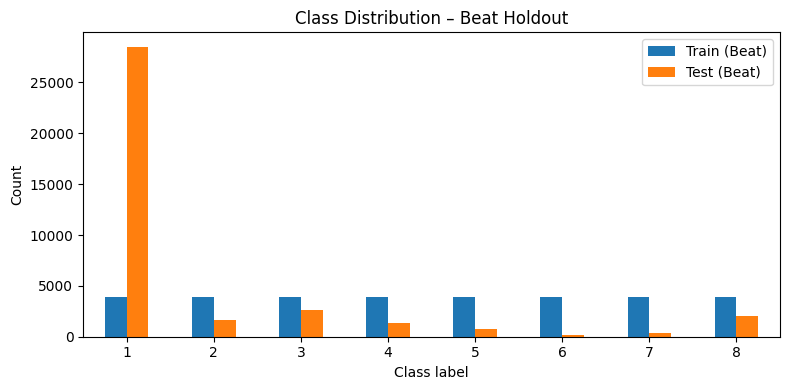


Class distribution – Patient Holdout:
   Train (Patient)  Test (Patient)
1            25044          9363.0
2            25044             0.0
3            25044             0.0
4            25044          1087.0
5            25044             0.0
6            25044           387.0
7            25043          1138.0
8            25044          2506.0


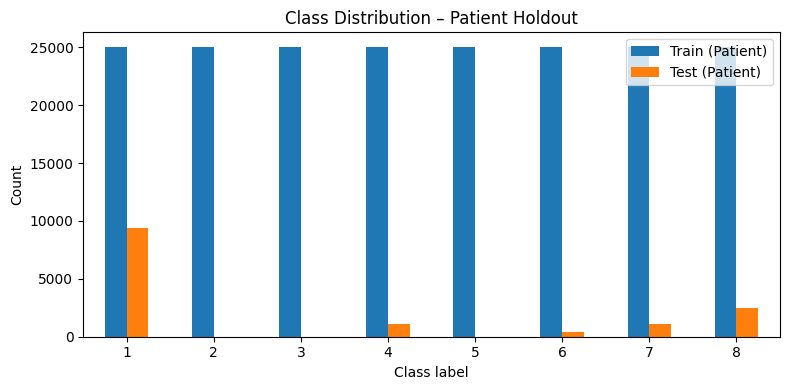

In [10]:
y_train_beats_series = pd.Series(y_train_beats, name="Beat_train_labels")
y_test_beats_series  = pd.Series(y_test_beats,  name="Beat_test_labels")

y_train_pat_series = pd.Series(y_train_pat, name="Pat_train_labels")
y_test_pat_series  = pd.Series(y_test_pat,  name="Pat_test_labels")

# Beat Holdout class distribution
beat_train_counts = y_train_beats_series.value_counts().sort_index()
beat_test_counts  = y_test_beats_series.value_counts().sort_index()

beat_dist_df = pd.DataFrame({
    "Train (Beat)": beat_train_counts,
    "Test (Beat)": beat_test_counts
}).fillna(0)

print("\nClass distribution – Beat Holdout:")
print(beat_dist_df)

ax = beat_dist_df.plot(kind="bar", figsize=(8, 4))
ax.set_xlabel("Class label")
ax.set_ylabel("Count")
ax.set_title("Class Distribution – Beat Holdout")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Patient Holdout class distribution
pat_train_counts = y_train_pat_series.value_counts().sort_index()
pat_test_counts  = y_test_pat_series.value_counts().sort_index()

pat_dist_df = pd.DataFrame({
    "Train (Patient)": pat_train_counts,
    "Test (Patient)": pat_test_counts
}).fillna(0)

print("\nClass distribution – Patient Holdout:")
print(pat_dist_df)

ax = pat_dist_df.plot(kind="bar", figsize=(8, 4))
ax.set_xlabel("Class label")
ax.set_ylabel("Count")
ax.set_title("Class Distribution – Patient Holdout")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### BASE MODELS

In [11]:
# Separate base models for each split
svm_beats_base, rf_beats_base = build_base_models()
svm_pat_base,  rf_pat_base    = build_base_models()

print("\nTraining base models on Beat Holdout...")
svm_beats_base.fit(X_train_beats, y_train_beats)
rf_beats_base.fit(X_train_beats, y_train_beats)

print("\nTraining base models on Patient Holdout...")
svm_pat_base.fit(X_train_pat, y_train_pat)
rf_pat_base.fit(X_train_pat, y_train_pat)

results_base = []

results_base.append(
    evaluate_model(svm_beats_base, X_test_beats, y_test_beats,
                   name="SVM (Beat Holdout, base)")
)
results_base.append(
    evaluate_model(rf_beats_base, X_test_beats, y_test_beats,
                   name="RF  (Beat Holdout, base)")
)
results_base.append(
    evaluate_model(svm_pat_base, X_test_pat, y_test_pat,
                   name="SVM (Patient Holdout, base)")
)
results_base.append(
    evaluate_model(rf_pat_base, X_test_pat, y_test_pat,
                   name="RF  (Patient Holdout, base)")
)

results_base_df = pd.DataFrame(results_base)
print("\n===== Base model summary =====")
print(results_base_df)



Training base models on Beat Holdout...

Training base models on Patient Holdout...


/opt/anaconda3/envs/penv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



==================== SVM (Beat Holdout, base) ====================
Accuracy : 0.9501
Precision: 0.9726
Recall   : 0.9501
F1-score : 0.9583

Classification report:
              precision    recall  f1-score   support

           1     0.9964    0.9419    0.9684     28501
           2     0.9891    0.9969    0.9930      1636
           3     0.9973    0.9880    0.9926      2581
           4     0.7690    0.9517    0.8507      1305
           5     0.6014    0.9105    0.7243       782
           6     0.1978    0.9372    0.3266       191
           7     0.6996    0.9511    0.8062       409
           8     0.9961    0.9936    0.9948      2036

    accuracy                         0.9501     37441
   macro avg     0.7808    0.9589    0.8321     37441
weighted avg     0.9726    0.9501    0.9583     37441

Confusion matrix:
[[26846    15     6   343   449   693   149     0]
 [    1  1631     0     1     0     0     3     0]
 [   17     0  2550     5     6     0     1     2]
 [   17     0 

/opt/anaconda3/envs/penv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/penv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/penv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs

#### Hyperparameter Tuning 

In [14]:
# ---- SVM TUNING: Beat subset only ----

# use subset of Beat train to make SVM tuning fast
max_samples = 10000
if X_train_beats.shape[0] > max_samples:
    X_svm_tune, _, y_svm_tune, _ = train_test_split(
        X_train_beats, y_train_beats,
        train_size=max_samples,
        stratify=y_train_beats,
        random_state=42
    )
else:
    X_svm_tune = X_train_beats
    y_svm_tune = y_train_beats

print("\nSVM tuning subset shape:", X_svm_tune.shape)

# small SVM grid
param_grid_svm_small = {
    "svm__C": [1, 10],
    "svm__gamma": ["scale", 0.1],
    "svm__kernel": ["rbf"]
}

svm_base_for_tune, _ = build_base_models()

svm_beats_tuned_temp, best_svm_params = quick_tune(
    svm_base_for_tune, param_grid_svm_small,
    X_svm_tune, y_svm_tune,
    name="SVM (Beat subset)"
)

# build final tuned SVM models for both splits using best params
svm_beats_tuned = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel=best_svm_params["svm__kernel"],
        C=best_svm_params["svm__C"],
        gamma=best_svm_params["svm__gamma"],
        max_iter=5000,
        random_state=42
    ))
])

svm_pat_tuned = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel=best_svm_params["svm__kernel"],
        C=best_svm_params["svm__C"],
        gamma=best_svm_params["svm__gamma"],
        max_iter=5000,
        random_state=42
    ))
])

print("\nTraining final tuned SVM on full Beat Holdout train...")
svm_beats_tuned.fit(X_train_beats, y_train_beats)

print("Training final tuned SVM on full Patient Holdout train...")
svm_pat_tuned.fit(X_train_pat, y_train_pat)




SVM tuning subset shape: (10000, 275)

Quick tuning SVM (Beat subset) ...
Fitting 2 folds for each of 4 candidates, totalling 8 fits


python(11564) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11565) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11568) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best params for SVM (Beat subset): {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best CV F1 (weighted) for SVM (Beat subset): 0.9553

Training final tuned SVM on full Beat Holdout train...


/opt/anaconda3/envs/penv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training final tuned SVM on full Patient Holdout train...


/opt/anaconda3/envs/penv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [15]:
# ---- RF TUNING: Beat only ----

# small RF grid
param_grid_rf_small = {
    "rf__n_estimators": [100, 300],
    "rf__max_depth": [None, 10]
}

_, rf_base_for_tune = build_base_models()

rf_beats_tuned_temp, best_rf_params = quick_tune(
    rf_base_for_tune, param_grid_rf_small,
    X_train_beats, y_train_beats,
    name="RF (Beat Holdout)"
)



Quick tuning RF (Beat Holdout) ...
Fitting 2 folds for each of 4 candidates, totalling 8 fits


python(11620) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best params for RF (Beat Holdout): {'rf__max_depth': None, 'rf__n_estimators': 300}
Best CV F1 (weighted) for RF (Beat Holdout): 0.9762


In [16]:
# same best RF params for both splits
rf_beats_tuned = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=best_rf_params["rf__n_estimators"],
        max_depth=best_rf_params["rf__max_depth"],
        n_jobs=-1,
        random_state=42
    ))
])

rf_pat_tuned = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=best_rf_params["rf__n_estimators"],
        max_depth=best_rf_params["rf__max_depth"],
        n_jobs=-1,
        random_state=42
    ))
])


In [17]:
print("\nTraining final tuned RF on full Beat Holdout train...")
rf_beats_tuned.fit(X_train_beats, y_train_beats)

print("Training final tuned RF on full Patient Holdout train...")
rf_pat_tuned.fit(X_train_pat, y_train_pat)




Training final tuned RF on full Beat Holdout train...
Training final tuned RF on full Patient Holdout train...


,steps,"[('imputer', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,n_estimators,300


#### EVALUATE TUNED MODELS

In [18]:
results_tuned = []

results_tuned.append(
    evaluate_model(svm_beats_tuned, X_test_beats, y_test_beats,
                   name="SVM (Beat Holdout, tuned)")
)
results_tuned.append(
    evaluate_model(rf_beats_tuned, X_test_beats, y_test_beats,
                   name="RF  (Beat Holdout, tuned)")
)
results_tuned.append(
    evaluate_model(svm_pat_tuned, X_test_pat, y_test_pat,
                   name="SVM (Patient Holdout, tuned)")
)
results_tuned.append(
    evaluate_model(rf_pat_tuned, X_test_pat, y_test_pat,
                   name="RF  (Patient Holdout, tuned)")
)

results_tuned_df = pd.DataFrame(results_tuned)
print("\n===== Tuned model summary =====")
print(results_tuned_df)



==================== SVM (Beat Holdout, tuned) ====================
Accuracy : 0.9655
Precision: 0.9764
Recall   : 0.9655
F1-score : 0.9692

Classification report:
              precision    recall  f1-score   support

           1     0.9969    0.9613    0.9788     28501
           2     0.9897    0.9988    0.9942      1636
           3     0.9899    0.9911    0.9905      2581
           4     0.8178    0.9632    0.8846      1305
           5     0.6133    0.9105    0.7329       782
           6     0.3509    0.9424    0.5114       191
           7     0.8067    0.9487    0.8719       409
           8     0.9961    0.9936    0.9948      2036

    accuracy                         0.9655     37441
   macro avg     0.8202    0.9637    0.8699     37441
weighted avg     0.9764    0.9655    0.9692     37441

Confusion matrix:
[[27398    14    23   246   429   310    81     0]
 [    1  1634     0     1     0     0     0     0]
 [   12     0  2558     6     4     0     1     0]
 [   14     1

/opt/anaconda3/envs/penv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/penv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/penv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs

#### Confusion matrix 

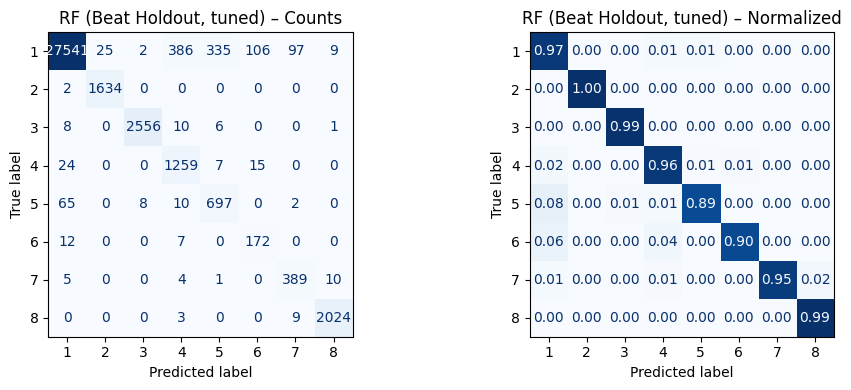

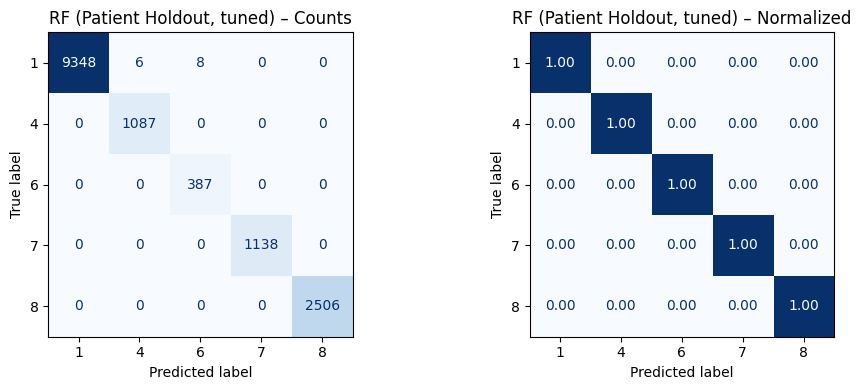

In [19]:
# RF – Beat Holdout
y_pred_rf_beats_tuned = rf_beats_tuned.predict(X_test_beats)
plot_confusion_matrices(y_test_beats, y_pred_rf_beats_tuned,
                        title_prefix="RF (Beat Holdout, tuned)")

# RF – Patient Holdout
y_pred_rf_pat_tuned = rf_pat_tuned.predict(X_test_pat)
plot_confusion_matrices(y_test_pat, y_pred_rf_pat_tuned,
                        title_prefix="RF (Patient Holdout, tuned)")


#### PERMUTATION IMPORTANCE (TUNED RF, BEAT)


Baseline accuracy (Beat Holdout, tuned RF): 0.9687775433348468
Block importances (accuracy drop):
[0.00950829 0.0021367  0.02302289 0.03386662 0.00510136 0.07475762
 0.12654577 0.05269624 0.00069443 0.00210999 0.00248391]


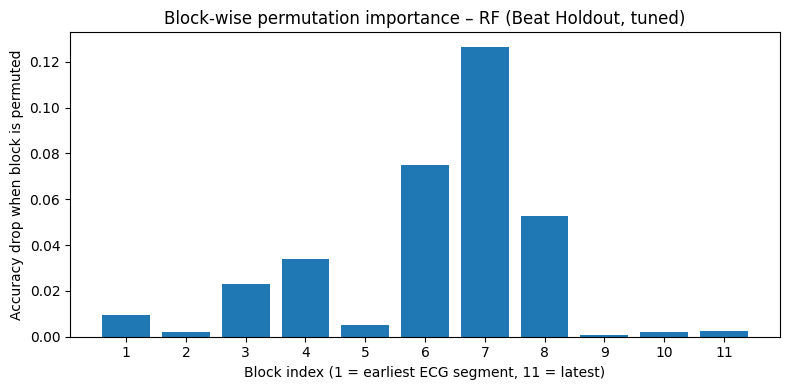

In [20]:
importances_blocks, baseline_acc = block_permutation_importance(
    rf_beats_tuned, X_test_beats, y_test_beats,
    n_blocks=11, random_state=42
)

print("\nBaseline accuracy (Beat Holdout, tuned RF):", baseline_acc)
print("Block importances (accuracy drop):")
print(importances_blocks)

block_indices = np.arange(1, len(importances_blocks) + 1)

plt.figure(figsize=(8, 4))
plt.bar(block_indices, importances_blocks)
plt.xlabel("Block index (1 = earliest ECG segment, 11 = latest)")
plt.ylabel("Accuracy drop when block is permuted")
plt.title("Block-wise permutation importance – RF (Beat Holdout, tuned)")
plt.xticks(block_indices)
plt.tight_layout()
plt.show()